# Kaggle Real Estate Price Prediction Model

This comprehensive notebook covers the complete machine learning workflow. We'll build and compare multiple models to predict house prices.

**IMPORTANT:** Update the `csv_path` and `target_col` variables below to match your dataset!

## 0. Configuration (MODIFY THIS SECTION FOR YOUR DATA)

In [1]:
# ===== IMPORTANT: UPDATE THESE FOR YOUR DATA =====
# Path to your CSV file
csv_path = 'melb_data.csv'  # Change this to your file

# Name of the target column (the price column)
target_col = 'Price'  # Change this if your column has a different name
# Common alternatives: 'Price', 'price', 'PRICE', 'target', 'y'

# Feature columns to use (leave empty to auto-detect numeric columns)
feature_columns = 'auto'
# If you want to use ALL numeric columns instead, use: feature_columns = 'auto'

print("Configuration set!")
print(f"CSV Path: {csv_path}")
print(f"Target Column: {target_col}")

Configuration set!
CSV Path: melb_data.csv
Target Column: Price


## 1. Load and Explore Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math

# Load the data
try:
    home_data = pd.read_csv(csv_path)
    print("✅ Data loaded successfully!")
except FileNotFoundError:
    print(f"❌ Error: File not found at {csv_path}")
    print("Please check the path and try again.")
    raise

# Display basic information about the dataset
print(f"\nDataset shape: {home_data.shape}")
print(f"\nColumn names:")
print(home_data.columns.tolist())

print(f"\nFirst few rows:")
print(home_data.head())

print(f"\nData types:")
print(home_data.dtypes)

print(f"\nMissing values:")
print(home_data.isnull().sum())

✅ Data loaded successfully!

Dataset shape: (13580, 21)

Column names:
['Suburb', 'Address', 'Rooms', 'Type', 'Price', 'Method', 'SellerG', 'Date', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'Propertycount']

First few rows:
       Suburb           Address  Rooms Type      Price Method SellerG  \
0  Abbotsford      85 Turner St      2    h  1480000.0      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h  1035000.0      S  Biggin   
2  Abbotsford      5 Charles St      3    h  1465000.0     SP  Biggin   
3  Abbotsford  40 Federation La      3    h   850000.0     PI  Biggin   
4  Abbotsford       55a Park St      4    h  1600000.0     VB  Nelson   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
1  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0     

## 2. Verify Target Column and Prepare Features

In [3]:
# Verify target column exists
if target_col not in home_data.columns:
    print(f"❌ Error: Column '{target_col}' not found in dataset!")
    print(f"Available columns: {home_data.columns.tolist()}")
    raise KeyError(f"Column '{target_col}' does not exist. Please check the target_col variable.")

# Define the target variable
y = home_data[target_col]
print(f"✅ Target column '{target_col}' found!")
print(f"Target shape: {y.shape}")
print(f"Target statistics:")
print(y.describe())

# Define feature columns
if feature_columns == 'auto':
    # Auto-detect all numeric columns (except target)
    feature_columns = [col for col in home_data.columns if home_data[col].dtype in ['int64', 'float64'] and col != target_col]
    print(f"\nAuto-detected {len(feature_columns)} numeric features")

# Verify all feature columns exist
missing_cols = [col for col in feature_columns if col not in home_data.columns]
if missing_cols:
    print(f"❌ Error: Feature columns not found: {missing_cols}")
    print(f"Available columns: {home_data.columns.tolist()}")
    raise KeyError(f"Columns {missing_cols} not found in dataset.")

# Create feature matrix X
X = home_data[feature_columns].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Features: {feature_columns}")
print(f"\nFeatures preview:")
print(X.head())

✅ Target column 'Price' found!
Target shape: (13580,)
Target statistics:
count    1.358000e+04
mean     1.075684e+06
std      6.393107e+05
min      8.500000e+04
25%      6.500000e+05
50%      9.030000e+05
75%      1.330000e+06
max      9.000000e+06
Name: Price, dtype: float64

Auto-detected 12 numeric features

Features shape: (13580, 12)
Features: ['Rooms', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

Features preview:
   Rooms  Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  BuildingArea  \
0      2       2.5    3067.0       2.0       1.0  1.0     202.0           NaN   
1      2       2.5    3067.0       2.0       1.0  0.0     156.0          79.0   
2      3       2.5    3067.0       3.0       2.0  0.0     134.0         150.0   
3      3       2.5    3067.0       3.0       2.0  1.0      94.0           NaN   
4      4       2.5    3067.0       3.0       1.0  2.0     120.0         142

## 3. Handle Missing Values in Features

In [4]:
# Check for missing values
missing_count = X.isnull().sum()
if missing_count.sum() > 0:
    print("Missing values found:")
    print(missing_count[missing_count > 0])
    print("\nDropping rows with missing values...")
    X = X.dropna()
    y = y.loc[X.index]
    print(f"✅ After removing missing values: {X.shape}")
else:
    print("✅ No missing values in features!")

# Remove any rows with missing target values
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]
print(f"✅ Final dataset shape: {X.shape}")

Missing values found:
Car               62
BuildingArea    6450
YearBuilt       5375
dtype: int64

Dropping rows with missing values...
✅ After removing missing values: (6830, 12)
✅ Final dataset shape: (6830, 12)


## 4. Split Data into Training and Validation Sets

In [5]:
# Split the data: 80% training, 20% validation
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

print(f"Training set size: {train_X.shape[0]}")
print(f"Validation set size: {val_X.shape[0]}")
print(f"Total samples: {len(X)}")

Training set size: 5464
Validation set size: 1366
Total samples: 6830


## 5. Model 1: Decision Tree Regressor (Baseline)

In [6]:
# Create and train a basic Decision Tree model
dt_model = DecisionTreeRegressor(random_state=1)
dt_model.fit(train_X, train_y)

# Make predictions
dt_predictions = dt_model.predict(val_X)

# Calculate Mean Absolute Error
dt_mae = mean_absolute_error(val_y, dt_predictions)
print(f"Decision Tree - Validation MAE: ${dt_mae:,.0f}")

# Compare top predictions with actual values
print(f"\nTop 5 Predictions vs Actual Values:")
comparison_df = pd.DataFrame({
    'Predicted': dt_predictions[:5],
    'Actual': val_y.values[:5],
    'Difference': dt_predictions[:5] - val_y.values[:5]
})
print(comparison_df)

Decision Tree - Validation MAE: $229,232

Top 5 Predictions vs Actual Values:
   Predicted     Actual  Difference
0  1450000.0  1785000.0   -335000.0
1  1856000.0  1060000.0    796000.0
2  1850000.0  1740000.0    110000.0
3   800000.0  1125000.0   -325000.0
4  1250000.0   680000.0    570000.0


## 6. Finding Optimal Tree Size (Hyperparameter Tuning)

In [7]:
# Test different max_leaf_nodes values
candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500]

# Calculate MAE for each tree size
scores = {}
for leaf_size in candidate_max_leaf_nodes:
    model = DecisionTreeRegressor(max_leaf_nodes=leaf_size, random_state=1)
    model.fit(train_X, train_y)
    preds = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds)
    scores[leaf_size] = mae
    print(f"max_leaf_nodes={leaf_size:4d} --> MAE: ${mae:,.0f}")

# Find the best tree size
best_tree_size = min(scores, key=scores.get)
print(f"\nBest max_leaf_nodes: {best_tree_size} with MAE: ${scores[best_tree_size]:,.0f}")

max_leaf_nodes=   5 --> MAE: $344,615
max_leaf_nodes=  25 --> MAE: $263,011
max_leaf_nodes=  50 --> MAE: $239,002
max_leaf_nodes= 100 --> MAE: $226,176
max_leaf_nodes= 250 --> MAE: $216,263
max_leaf_nodes= 500 --> MAE: $208,956

Best max_leaf_nodes: 500 with MAE: $208,956


## 7. Train Final Decision Tree with Optimal Size

In [8]:
# Train the final model using ALL data with optimal tree size
final_dt_model = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state=1)
final_dt_model.fit(X, y)

print(f"Final Decision Tree model trained with max_leaf_nodes={best_tree_size}")
print(f"Total samples used: {len(X)}")

Final Decision Tree model trained with max_leaf_nodes=500
Total samples used: 6830


## 8. Model 2: Random Forest Regressor

In [9]:
# Create and train Random Forest model
rf_model = RandomForestRegressor(random_state=1, n_estimators=100)
rf_model.fit(train_X, train_y)

# Make predictions
rf_predictions = rf_model.predict(val_X)

# Calculate Mean Absolute Error
rf_mae = mean_absolute_error(val_y, rf_predictions)
print(f"Random Forest - Validation MAE: ${rf_mae:,.0f}")

# Compare top predictions
print(f"\nTop 5 Predictions vs Actual Values:")
rf_comparison_df = pd.DataFrame({
    'Predicted': rf_predictions[:5],
    'Actual': val_y.values[:5],
    'Difference': rf_predictions[:5] - val_y.values[:5]
})
print(rf_comparison_df)

Random Forest - Validation MAE: $173,738

Top 5 Predictions vs Actual Values:
    Predicted     Actual  Difference
0  1767375.00  1785000.0   -17625.00
1  1485634.00  1060000.0   425634.00
2  1572672.88  1740000.0  -167327.12
3  1086050.00  1125000.0   -38950.00
4  1068300.00   680000.0   388300.00


## 9. Model Comparison

In [10]:
# Compare all models
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"Decision Tree (Basic) MAE: ${dt_mae:,.0f}")
print(f"Decision Tree (Optimized) MAE: ${scores[best_tree_size]:,.0f}")
print(f"Random Forest MAE: ${rf_mae:,.0f}")
print("=" * 60)

# Calculate improvement
if dt_mae > 0:
    improvement = ((dt_mae - rf_mae) / dt_mae) * 100
    print(f"\nRandom Forest improvement over baseline: {improvement:.1f}%")

MODEL COMPARISON
Decision Tree (Basic) MAE: $229,232
Decision Tree (Optimized) MAE: $208,956
Random Forest MAE: $173,738

Random Forest improvement over baseline: 24.2%


## 10. Feature Importance (Random Forest)

Feature Importance (Random Forest):
          Feature  Importance
7    BuildingArea    0.374746
1        Distance    0.156052
2        Postcode    0.110490
8       YearBuilt    0.101089
6        Landsize    0.068093
9       Lattitude    0.056437
10     Longtitude    0.048690
0           Rooms    0.024093
11  Propertycount    0.019746
4        Bathroom    0.017775
5             Car    0.011591
3        Bedroom2    0.011197


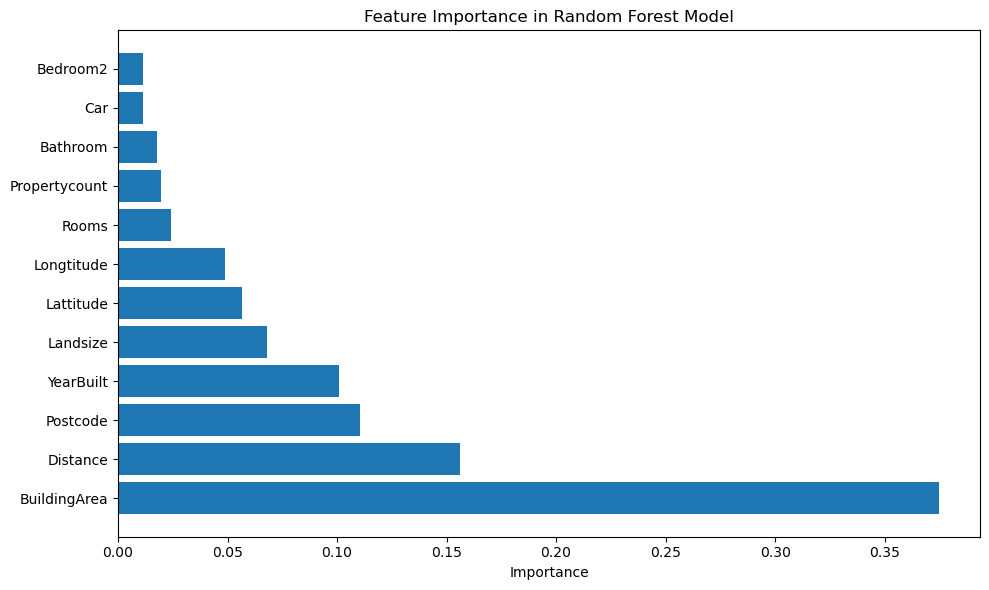

In [11]:
# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()

## 11. Cross-Validation and Hyperparameter Tuning

In [12]:
# Function to compute CV score for different n_estimators
def get_cv_score(n_estimators: int) -> float:
    """
    Return average MAE over 3-fold cross-validation
    for a RandomForestRegressor with given n_estimators.
    """
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=1
    )
    # Multiply by -1 because sklearn returns negative MAE for neg_mean_absolute_error
    scores = -1 * cross_val_score(
        model,
        X,
        y,
        cv=3,
        scoring="neg_mean_absolute_error"
    )
    return scores.mean()

# Test different values for number of trees
n_values = [50, 100, 150, 200, 250, 300, 350, 400]
cv_results = {n: get_cv_score(n) for n in n_values}

print("Cross-validation results (n_estimators -> MAE):")
for n, score in cv_results.items():
    print(f"{n}: ${score:,.0f}")

Cross-validation results (n_estimators -> MAE):
50: $213,283
100: $212,392
150: $211,795
200: $212,433
250: $212,529
300: $212,316
350: $212,383
400: $212,035


## 12. Visualize Cross-Validation Results

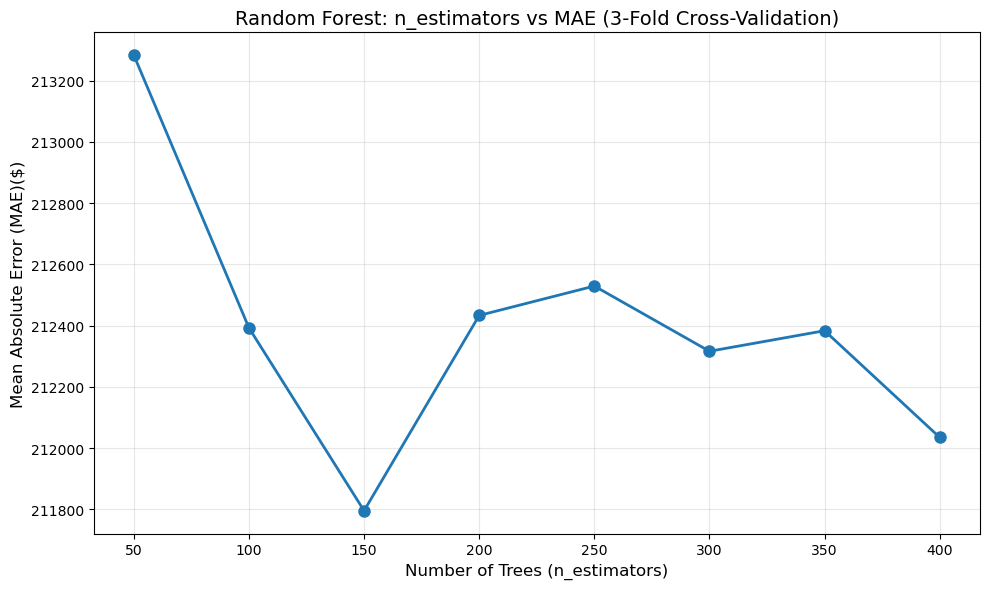


✅ Best n_estimators: 150 with MAE: $211,795


In [13]:
# Plot n_estimators vs MAE
plt.figure(figsize=(10, 6))
plt.plot(list(cv_results.keys()), list(cv_results.values()), marker="o", linewidth=2, markersize=8)
plt.xlabel("Number of Trees (n_estimators)", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)($)", fontsize=12)
plt.title("Random Forest: n_estimators vs MAE (3-Fold Cross-Validation)", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find best n_estimators
best_n_estimators = min(cv_results, key=cv_results.get)
print(f"\n✅ Best n_estimators: {best_n_estimators} with MAE: ${cv_results[best_n_estimators]:,.0f}")

## 13. Model Evaluation Metrics

In [14]:
# Calculate additional metrics for Random Forest
rmse = math.sqrt(mean_squared_error(val_y, rf_predictions))
r2 = r2_score(val_y, rf_predictions)

print("Random Forest Model Evaluation Metrics:")
print(f" Mean Absolute Error (MAE): ${rf_mae:,.0f}")
print(f" Root Mean Squared Error (RMSE): ${rmse:,.0f}")
print(f" R² Score: {r2:.4f}")

# Calculate percentage error
percentage_error = (rf_mae / val_y.mean()) * 100
print(f" Mean Percentage Error: {percentage_error:.2f}%")

Random Forest Model Evaluation Metrics:
 Mean Absolute Error (MAE): $173,738
 Root Mean Squared Error (RMSE): $332,026
 R² Score: 0.7937
 Mean Percentage Error: 16.14%


## 14. Make Predictions on New Data

In [15]:
# Example: Make predictions on validation set using Random Forest
sample_predictions = rf_model.predict(val_X.head(10))

print("Sample Predictions on Validation Data (Random Forest):")
sample_df = pd.DataFrame({
    'Predicted Price': sample_predictions,
    'Actual Price': val_y.head(10).values,
    'Difference': sample_predictions - val_y.head(10).values,
    'Error %': ((sample_predictions - val_y.head(10).values) / val_y.head(10).values * 100).round(2)
})
print(sample_df)

Sample Predictions on Validation Data (Random Forest):
   Predicted Price  Actual Price  Difference  Error %
0       1767375.00     1785000.0   -17625.00    -0.99
1       1485634.00     1060000.0   425634.00    40.15
2       1572672.88     1740000.0  -167327.12    -9.62
3       1086050.00     1125000.0   -38950.00    -3.46
4       1068300.00      680000.0   388300.00    57.10
5        754435.00      830000.0   -75565.00    -9.10
6        713670.00      742500.0   -28830.00    -3.88
7       1889620.00     1570000.0   319620.00    20.36
8       1939098.76     3025000.0 -1085901.24   -35.90
9        966230.00      875000.0    91230.00    10.43


## 15. Summary and Key Insights

In [17]:
print("\n" + "=" * 60)
print("MACHINE LEARNING PROJECT SUMMARY")
print("=" * 60)
print(f"\nDataset: House Price Prediction")
print(f"Total Samples: {len(X)}")
print(f"Features Used: {len(feature_columns)}")
print(f"Target Variable: {target_col}")

print(f"\nModels Trained:")
print(f" 1. Decision Tree (Baseline)")
print(f" 2. Decision Tree (Optimized with max_leaf_nodes={best_tree_size})")
print(f" 3. Random Forest (100 trees)")

print(f"\nBest Model: Random Forest")
print(f"Best Validation MAE: ${rf_mae:,.0f}")
print(f"Best R² Score: {r2:.4f}")

print(f"\nTop 3 Most Important Features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f" {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "=" * 60)


MACHINE LEARNING PROJECT SUMMARY

Dataset: House Price Prediction
Total Samples: 6830
Features Used: 12
Target Variable: Price

Models Trained:
 1. Decision Tree (Baseline)
 2. Decision Tree (Optimized with max_leaf_nodes=500)
 3. Random Forest (100 trees)

Best Model: Random Forest
Best Validation MAE: $173,738
Best R² Score: 0.7937

Top 3 Most Important Features:
 BuildingArea: 0.3747
 Distance: 0.1561
 Postcode: 0.1105

